# Nhận diện cảm xúc từ âm thanh
Sử dụng Keras + CNN (Convolutional neural network)

## I. Import thư viện cần thiết

In [25]:
import keras.src.saving.saving_api
# Import necessary libraries

# pandas and numpy for data manipulation and numerical operations
import pandas as pd
import numpy as np

# os and sys for file and system path handling
import os
import sys

# librosa is a library for audio processing, used here to extract features from audio files
import librosa
import librosa.display

# seaborn and matplotlib for data visualization (plots)
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn libraries for preprocessing and splitting data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# sklearn libraries for generating confusion matrix and detailed classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Seaborn library for visualization of the confusion matrix
import seaborn as sns

# IPython's Audio class for playing audio files directly in Jupyter
from IPython.display import Audio

# Keras for deep learning, specifically for creating and training the neural network
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# Suppress warnings to avoid cluttering the output
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## II. Chuẩn bị dữ liệu - Data Preparation
Khai báo đường dẫn đến các tập dữ liệu

In [26]:
# Define dataset paths

# RAVDESS: Ryerson Audio-Visual Database of Emotional Speech and Song
Ravdess = "data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/archive/"

# CREMA-D: Crowd-sourced Emotional Multimodal Actors Dataset
Crema = "data/cremad/AudioWAV/"

# TESS: Toronto Emotional Speech Set
Tess = "data/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"

# SAVEE: Surrey Audio-Visual Expressed Emotion
Savee = "data/surrey-audiovisual-expressed-emotion-savee/ALL/"

###     1. RAVDESS

In [27]:
# Get the list of subdirectories in the RAVDESS dataset directory
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []  # List to store the emotion label for each audio file
file_path = []  # List to store the full path of each audio file

for dir in ravdess_directory_list:
    if dir == '.DS_Store':  # Skip MacOS system file
        continue
    # Each subdirectory corresponds to an actor and contains audio files
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]  # Remove the file extension (.wav)
        part = part.split('-')  # Split the filename into parts based on RAVDESS naming convention

        # The third element in the filename represents the emotion
        file_emotion.append(int(part[2]))

        # Construct and save the full path to the audio file
        file_path.append(Ravdess + dir + '/' + file)

# Create a DataFrame for the extracted emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a DataFrame for the audio file paths
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine the two DataFrames into one
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Map numeric emotion codes to actual emotion labels
Ravdess_df.Emotions.replace(
    {
        1: 'neutral',
        2: 'calm',
        3: 'happy',
        4: 'sad',
        5: 'angry',
        6: 'fear',
        7: 'disgust',
        8: 'surprise'
    },
    inplace=True
)

# Display the first few rows of the processed DataFrame
Ravdess_df.head()

,Emotions,Path
0,happy,data/ravdess-emotional-speech-audio/audio_spee...
1,happy,data/ravdess-emotional-speech-audio/audio_spee...
2,calm,data/ravdess-emotional-speech-audio/audio_spee...
3,calm,data/ravdess-emotional-speech-audio/audio_spee...
4,neutral,data/ravdess-emotional-speech-audio/audio_spee...


###     2. CREMA-D

In [28]:
# Get the list of all audio files in the CREMA-D dataset directory
crema_directory_list = os.listdir(Crema)

file_emotion = []  # List to store emotion labels
file_path = []  # List to store file paths

for file in crema_directory_list:
    # Append the full file path to the list
    file_path.append(Crema + file)

    # Extract emotion code from the file name (e.g., '1001_DFA_ANG_XX.wav')
    part = file.split('_')

    # Map the emotion code to the corresponding emotion label
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')  # Fallback in case of unexpected code

# Create a DataFrame for the extracted emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a DataFrame for the corresponding file paths
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine emotion and path into one DataFrame
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the DataFrame
Crema_df.head()

,Emotions,Path
0,angry,data/cremad/AudioWAV/1022_ITS_ANG_XX.wav
1,angry,data/cremad/AudioWAV/1037_ITS_ANG_XX.wav
2,neutral,data/cremad/AudioWAV/1060_ITS_NEU_XX.wav
3,neutral,data/cremad/AudioWAV/1075_ITS_NEU_XX.wav
4,disgust,data/cremad/AudioWAV/1073_IOM_DIS_XX.wav


###     3. TESS

In [29]:
# Get the list of speaker folders in the TESS dataset directory
tess_directory_list = os.listdir(Tess)

file_emotion = []  # List to store emotion labels
file_path = []  # List to store full file paths

# Iterate through each speaker's folder
for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)  # Get list of audio files in the speaker folder
    for file in directories:
        # Extract the emotion from the file name (e.g., 'OAF_angry.wav')
        part = file.split('.')[0]
        part = part.split('_')[2]  # The third segment contains the emotion label

        # Handle special case: 'ps' stands for 'pleasant surprise'
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)

        # Append the full file path
        file_path.append(Tess + dir + '/' + file)

# Create DataFrame for extracted emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create DataFrame for corresponding file paths
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine both into a single DataFrame
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Preview the result
Tess_df.head()

,Emotions,Path
0,disgust,data/toronto-emotional-speech-set-tess/tess to...
1,disgust,data/toronto-emotional-speech-set-tess/tess to...
2,disgust,data/toronto-emotional-speech-set-tess/tess to...
3,disgust,data/toronto-emotional-speech-set-tess/tess to...
4,disgust,data/toronto-emotional-speech-set-tess/tess to...


###     4. SAVEE

In [30]:
# Get the list of all audio files in the SAVEE dataset directory
savee_directory_list = os.listdir(Savee)

file_emotion = []  # List to store emotion labels
file_path = []  # List to store full file paths

# Iterate through each file in the directory
for file in savee_directory_list:
    file_path.append(Savee + file)  # Construct full file path

    # Extract the emotion code from the filename
    part = file.split('_')[1]
    ele = part[:-6]  # Remove the numerical part and extension

    # Map short emotion codes to full labels
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# Create a DataFrame for the extracted emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a DataFrame for the corresponding file paths
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine the two DataFrames into one
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# Preview the result
Savee_df.head()

,Emotions,Path
0,sad,data/surrey-audiovisual-expressed-emotion-save...
1,sad,data/surrey-audiovisual-expressed-emotion-save...
2,neutral,data/surrey-audiovisual-expressed-emotion-save...
3,surprise,data/surrey-audiovisual-expressed-emotion-save...
4,neutral,data/surrey-audiovisual-expressed-emotion-save...


### => Kết hợp các tập dữ liệu đã tải

In [31]:
# Combine datasets from all four sources (RAVDESS, CREMA-D, TESS, SAVEE)
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)

# Xoá trộn tránh bias
data_path = data_path.sample(frac=1).reset_index(drop=True)

# Save the combined DataFrame to a CSV file for future use
data_path.to_csv("data_path.csv", index=False)

# Preview the first few rows of the combined dataset
data_path.head()

,Emotions,Path
0,happy,data/ravdess-emotional-speech-audio/audio_spee...
1,happy,data/ravdess-emotional-speech-audio/audio_spee...
2,calm,data/ravdess-emotional-speech-audio/audio_spee...
3,calm,data/ravdess-emotional-speech-audio/audio_spee...
4,neutral,data/ravdess-emotional-speech-audio/audio_spee...


## 📊Biểu đồ số lượng mẫu cho mỗi cảm xúc

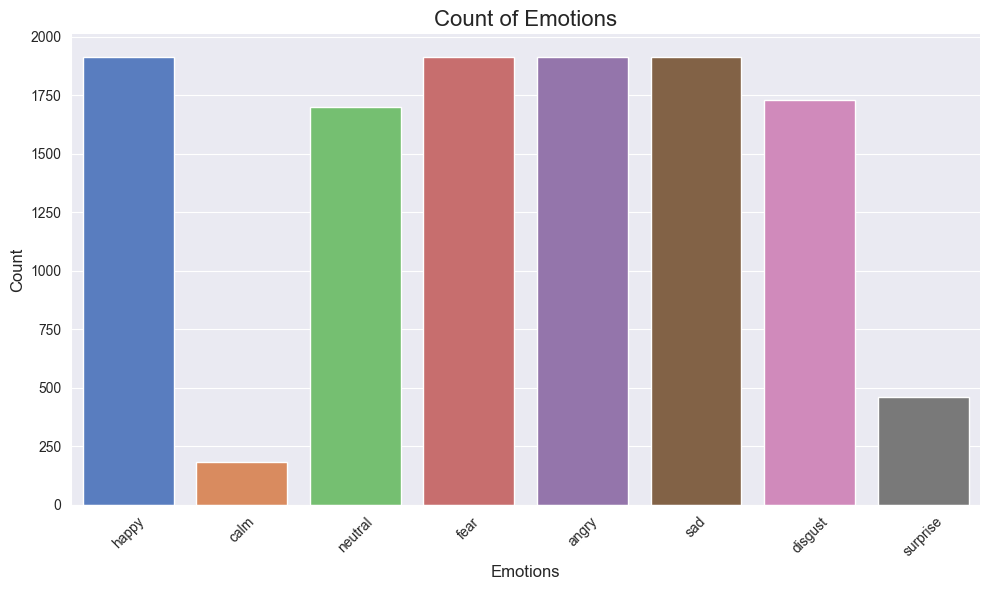

In [32]:
# Plotting the number of samples for each emotion

plt.figure(figsize=(10, 6))  # Set figure size for better readability

# Create a count plot for the 'Emotions' column
sns.countplot(x='Emotions', data=data_path, palette='muted')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Set plot titles and labels
plt.title('Count of Emotions', fontsize=16)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Remove top and right borders for a cleaner look
sns.despine(top=True, right=True, left=False, bottom=False)

# Automatically adjust subplot parameters to fit the plot
plt.tight_layout()

# Show the final plot
plt.show()

## III. Khám phá và trực quan dữ liệu - (Exploratory Data Analysis - EDA):
##### 1. Biểu đồ dạng sóng (waveform).
##### 2. Quang phổ âm thanh (spectrogram) - biểu diễn tín hiệu âm thanh trong miền tần số theo thời gian.

In [33]:
# Function to create a waveplot for a given emotion and audio data
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))  # Set figure size
    plt.title(f'Waveplot for audio with {e} emotion', size=15)  # Title of the plot
    plt.plot(np.linspace(0, len(data) / sr, num=len(data)), data, alpha=0.7)  # Plot audio data over time
    plt.xlabel("Time (s)")  # X-axis label
    plt.ylabel("Amplitude")  # Y-axis label
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()  # Display the plot


# Function to create a spectrogram for a given emotion and audio data
def create_spectrogram(data, sr, e):
    # Compute the Short-Time Fourier Transform (STFT)
    X = librosa.stft(data)
    # Convert amplitude to decibels
    Xdb = librosa.amplitude_to_db(np.abs(X))
    plt.figure(figsize=(12, 3))  # Set figure size
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)  # Title of the plot
    # Display the spectrogram with the amplitude in decibels
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")  # Add color bar
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()  # Display the plot

In [ ]:
def visualize_emotion(emotion, data_path):
    try:
        # Lấy file đầu tiên có emotion tương ứng
        path = np.array(data_path.Path[data_path.Emotions == emotion])[0]

        # Load audio
        data, sampling_rate = librosa.load(path, sr=None)

        # Vẽ sóng âm thanh
        create_waveplot(data, sampling_rate, emotion)

        # Vẽ spectrogram
        create_spectrogram(data, sampling_rate, emotion)

        # Phát audio trong notebook
        display(Audio(path))

    except IndexError:
        print(f"No audio files found for emotion: {emotion}")

In [ ]:
visualize_emotion('happy', data_path)

visualize_emotion('sad', data_path)

visualize_emotion('fear', data_path)

visualize_emotion('angry', data_path)

## IV. Mở rộng dữ liêu - Data Augmentation

In [38]:
# Data Augmentation functions

def noise(data):
    # Generate random noise amplitude based on the maximum value of the data
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)  # Random amplitude of noise
    # Add Gaussian noise to the original signal
    data = data + noise_amp * np.random.normal(size=data.shape[0])  # Apply noise to the audio data
    return data


def stretch(data, rate=0.8):
    # Ensure that data is a numpy array and of type float32 for time-stretching
    return librosa.effects.time_stretch(np.array(data).astype(np.float32),
                                        rate=rate)  # Stretch the audio signal in time


def shift(data):
    # Generate a random shift range for shifting the audio signal in time
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)  # Random shift in milliseconds
    # Shift the audio data by the computed range using np.roll
    return np.roll(data, shift_range)  # Shift the audio data in time


def pitch(data, sampling_rate, pitch_factor=0.7):
    # Ensure that data is a numpy array and of type float32 for pitch shifting
    data = np.array(data)
    # Apply pitch shift by a factor (in steps), which will change the pitch of the audio signal
    return librosa.effects.pitch_shift(data.astype(np.float32), sr=sampling_rate, n_steps=pitch_factor)


# Taking any example from the dataset and testing the augmentation functions
path = np.array(data_path.Path)[1]  # Example audio file path
data, sample_rate = librosa.load(path, sr=None)  # Load the audio file and obtain its data and sample rate

#### 1. Ví dụ đơn giản trực quan hoá âm thanh theo dạng sóng
-> Kiểm tra và đánh giá chất lượng dữ liệu đầu vào.

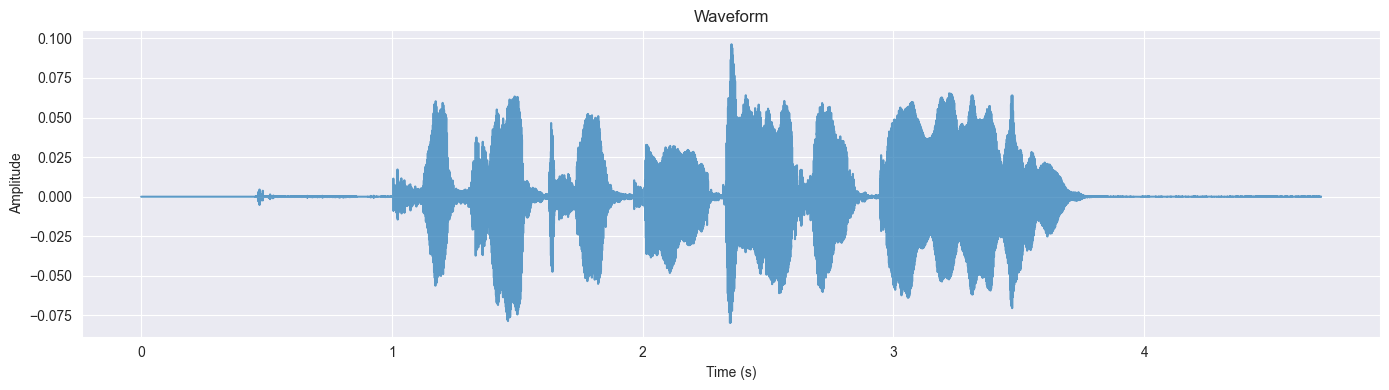

In [39]:
# Simple audio waveform visualization

# Create a figure with a specified size
plt.figure(figsize=(14, 4))

# Plot the audio signal data as a waveform.
# `np.linspace` is used to create time values based on the number of samples and the sample rate.
plt.plot(np.linspace(0, len(data) / sample_rate, num=len(data)), data, alpha=0.7)

# Set the title of the plot
plt.title("Waveform")

# Label the x-axis as "Time (s)"
plt.xlabel("Time (s)")

# Label the y-axis as "Amplitude"
plt.ylabel("Amplitude")

# Automatically adjust the layout to fit everything properly
plt.tight_layout()

# Display the plot
plt.show()

# Play the audio file using IPython's Audio class
Audio(path)

#### 2. Noise Injection Visualization (thêm nhiễu vào tín hiệu gốc).

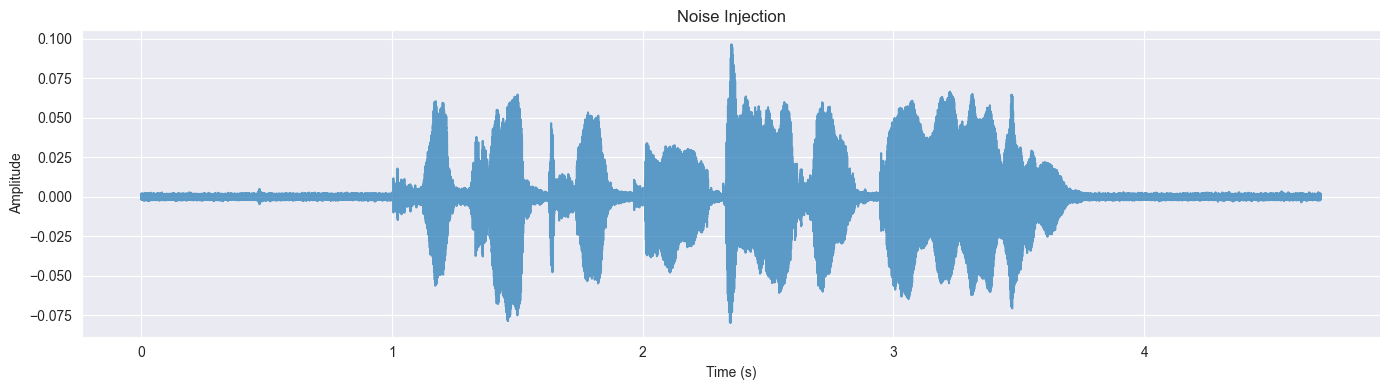

In [40]:
# Noise Injection: Adding random noise to the audio signal

# Inject noise into the original audio data
x = noise(data)

# Create a figure for plotting the noisy signal
plt.figure(figsize=(14, 4))

# Plot the noisy signal as a waveform. `np.linspace` is used to create time values.
plt.plot(np.linspace(0, len(x) / sample_rate, num=len(x)), x, alpha=0.7)

# Set the title of the plot
plt.title("Noise Injection")

# Label the x-axis as "Time (s)" to indicate time duration
plt.xlabel("Time (s)")

# Label the y-axis as "Amplitude" to indicate the amplitude of the audio signal
plt.ylabel("Amplitude")

# Adjust the layout to avoid overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

# Play the noisy audio using IPython's Audio class
Audio(x, rate=sample_rate)

#### 3. Time Stretching Visualization - Thay đổi tốc độ phát âm mà không làm thay đổi cao độ (pitch).

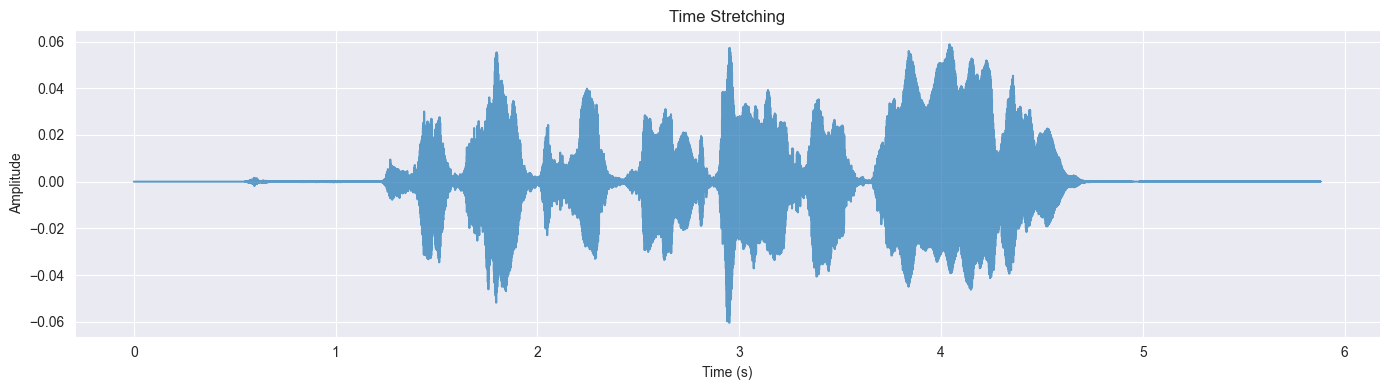

In [41]:
# Time Stretching: Changing the speed of the audio signal without altering its pitch

# Apply time-stretching to the original audio data
x = stretch(data)

# Create a figure for plotting the stretched signal
plt.figure(figsize=(14, 4))

# Plot the stretched signal as a waveform. `np.linspace` is used to create time values.
plt.plot(np.linspace(0, len(x) / sample_rate, num=len(x)), x, alpha=0.7)

# Set the title of the plot to indicate it's for time-stretching
plt.title("Time Stretching")

# Label the x-axis as "Time (s)" to indicate time duration
plt.xlabel("Time (s)")

# Label the y-axis as "Amplitude" to indicate the amplitude of the audio signal
plt.ylabel("Amplitude")

# Adjust the layout to avoid overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

# Play the time-stretched audio using IPython's Audio class
Audio(x, rate=sample_rate)

#### 4.Time Shifting Visualization – Dịch chuyển tín hiệu âm thanh theo thời gian.

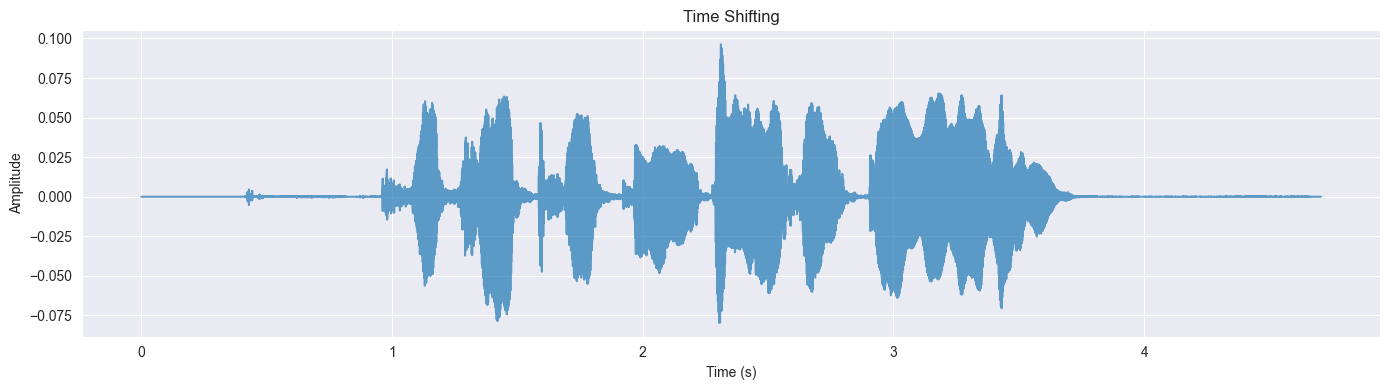

In [42]:
# Time Shifting: Shifting the audio signal in time (delays or advances the signal)

# Apply time-shifting to the original audio data
x = shift(data)

# Create a figure for plotting the shifted signal
plt.figure(figsize=(14, 4))

# Plot the shifted signal as a waveform. `np.linspace` is used to create time values.
plt.plot(np.linspace(0, len(x) / sample_rate, num=len(x)), x, alpha=0.7)

# Set the title of the plot to indicate it's for time-shifting
plt.title("Time Shifting")

# Label the x-axis as "Time (s)" to indicate time duration
plt.xlabel("Time (s)")

# Label the y-axis as "Amplitude" to indicate the amplitude of the audio signal
plt.ylabel("Amplitude")

# Adjust the layout to avoid overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

# Play the time-shifted audio using IPython's Audio class
Audio(x, rate=sample_rate)

#### 5. Pitch Shifting Visualization — Thay đổi cao độ (pitch) của tín hiệu âm thanh mà không thay đổi tốc độ phát.

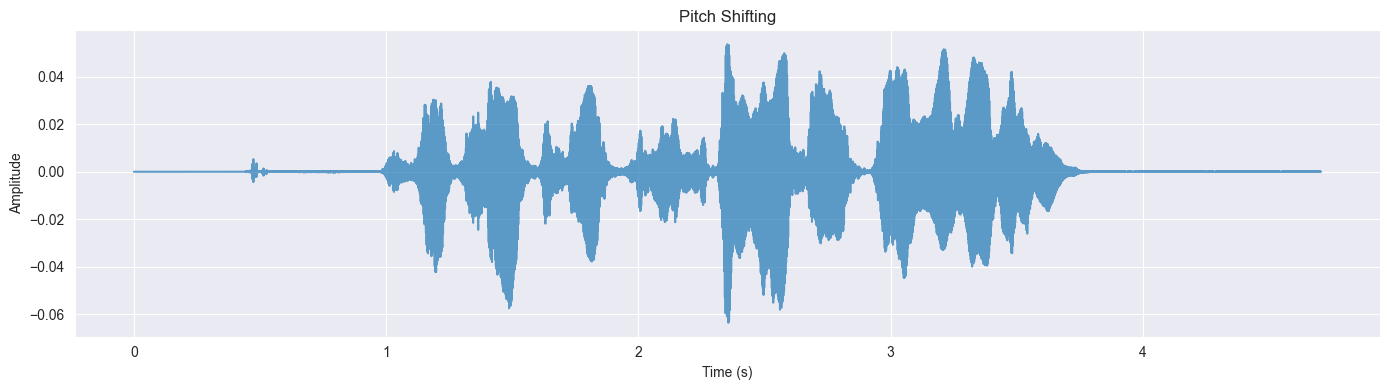

In [43]:
# Pitch Shifting: Changing the pitch (frequency) of the audio signal

# Apply pitch-shifting to the original audio data
x = pitch(data, sample_rate)

# Create a figure for plotting the pitch-shifted signal
plt.figure(figsize=(14, 4))

# Plot the pitch-shifted signal as a waveform. `np.linspace` is used to create time values.
plt.plot(np.linspace(0, len(x) / sample_rate, num=len(x)), x, alpha=0.7)

# Set the title of the plot to indicate it's for pitch-shifting
plt.title("Pitch Shifting")

# Label the x-axis as "Time (s)" to indicate time duration
plt.xlabel("Time (s)")

# Label the y-axis as "Amplitude" to indicate the amplitude of the audio signal
plt.ylabel("Amplitude")

# Adjust the layout to avoid overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

# Play the pitch-shifted audio using IPython's Audio class
Audio(x, rate=sample_rate)

## V. Trích xuất đặc trưng - Feature Extraction

In [44]:
# Feature Extraction (updated for newer APIs)
def extract_features(data):
    """
    This function extracts various audio features from the given audio data.
    Features include zero-crossing rate (ZCR), chroma_stft, MFCC, RMS, and mel spectrogram.
    """
    result = np.array([])  # Initialize an empty array to store features

    # Zero-Crossing Rate (ZCR): Measure of how many times the signal changes sign
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # Append the ZCR feature to result array

    # Chroma Short-Time Fourier Transform (chroma_stft): Measures harmonic and melodic content
    stft = np.abs(librosa.stft(data))  # Short-time Fourier transform of the audio signal
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)  # Compute chroma features
    result = np.hstack((result, chroma_stft))  # Append the chroma feature to result array

    # Mel-frequency Cepstral Coefficients (MFCC): Represent the short-term power spectrum of sound
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)  # Extract 13 MFCCs
    result = np.hstack((result, mfcc))  # Append the MFCC feature to result array

    # Root Mean Square (RMS): Energy of the audio signal
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)  # Calculate RMS value
    result = np.hstack((result, rms))  # Append the RMS feature to result array

    # Mel Spectrogram: Spectrogram representation of the audio signal using Mel scale
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)  # Extract Mel spectrogram
    result = np.hstack((result, mel))  # Append the Mel spectrogram feature to result array

    return result  # Return the array of extracted features


def get_features(path):
    """
    This function loads the audio data from the given path, extracts features from the original data,
    and applies data augmentation techniques (noise, stretching, and pitch shifting) to generate additional features.
    """
    # Load the audio file (duration and offset are specified to load a portion of the audio)
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Base features: Extract features from the original audio data
    res1 = extract_features(data)
    result = np.array(res1)  # Store base features as the result

    # Noise Augmentation: Apply noise injection and extract features from the noisy audio
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # Append noisy features to the result

    # Stretching and Pitch Augmentation: Apply time-stretching and pitch-shifting, then extract features
    new_data = stretch(data)  # Apply time-stretching
    data_stretch_pitch = pitch(new_data, sample_rate)  # Apply pitch shifting
    res3 = extract_features(data_stretch_pitch)  # Extract features from the stretched and pitch-shifted data
    result = np.vstack((result, res3))  # Append augmented features to the result

    return result  # Return the final feature set as a 2D array

##### Trích xuất đặc trưng cho toàn bộ dataset âm thanh kèm theo nhãn cảm xúc tương ứng

In [45]:
# Extract features for the entire dataset
X, Y = [], []  # Initialize lists to hold features (X) and labels (Y)

# Loop through each audio file and its associated emotion
for path, emotion in zip(data_path.Path, data_path.Emotions):

    # Extract features for the current audio file (including augmented variants)
    features = get_features(path)  # Extract features for the original audio and its augmented versions

    # Loop through the extracted features (original, noisy, stretched + pitched) and append them to X
    for feature in features:
        X.append(feature)  # Append the feature to the feature list (X)
        Y.append(emotion)  # Append the corresponding emotion label to the label list (Y)

        # Repeat 3 times because we have 3 variants (original, noise, and stretch + pitch)
        # This ensures that for each audio file, we have 3 corresponding entries in X and Y

##### Kiểm tra số: Mẫu đặc trưng (X) và số nhãn tương ứng với các mẫu (Y)

In [46]:
# Check the length of the feature set (X), the labels (Y), and the number of paths in data_path
len(X), len(Y), data_path.Path.shape

(35202, 35202, (11734,))

##### Lưu trữ dữ liệu đặc trưng và nhãn của toàn bộ dataset

In [47]:
# Save the features and labels into a DataFrame
Features = pd.DataFrame(X)
Features['labels'] = Y

# Save to a CSV file
Features.to_csv('features.csv', index=False)

# Display the first few rows
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,labels
0,0.199372,0.417950,0.373825,0.415148,0.317376,0.282046,0.333634,0.474305,0.650751,0.479009,...,0.005197,0.003718,0.001797,0.001733,0.001755,0.001782,0.002014,0.001989,0.000243,happy
1,0.266434,0.448048,0.439652,0.459616,0.378140,0.379732,0.444765,0.601086,0.714313,0.496091,...,0.005296,0.003821,0.001901,0.001834,0.001896,0.001898,0.002128,0.002112,0.000360,happy
2,0.221003,0.422446,0.336400,0.393972,0.304125,0.233535,0.261828,0.397599,0.674051,0.563159,...,0.000930,0.001232,0.001107,0.000474,0.000348,0.000391,0.000481,0.000328,0.000075,happy
3,0.176591,0.379039,0.350581,0.334654,0.298217,0.318153,0.400539,0.585148,0.601932,0.363154,...,0.000163,0.000151,0.000226,0.000261,0.000241,0.000168,0.000177,0.000124,0.000016,happy
4,0.205431,0.373332,0.388276,0.359314,0.355100,0.418317,0.546403,0.699651,0.501149,0.370156,...,0.000173,0.000163,0.000237,0.000270,0.000249,0.000177,0.000189,0.000138,0.000026,happy


##### Chuẩn bị dữ liệu đặc trưng và nhãn

In [48]:
# Features
X = Features.iloc[:, :-1].values  # Extract all columns except the last (labels)

# Labels
Y = Features['labels'].values  # Extract the labels column

##### Mã hóa nhãn dạng phân loại thành dạng vector one-hot (chuẩn hóa cho bài toán phân loại đa lớp).

In [49]:
# One-hot Encoding for labels
# As this is a multiclass classification problem, we are one-hot encoding the labels (Y).
encoder = OneHotEncoder(sparse_output=False)

# Convert labels (Y) to a 2D array (required by OneHotEncoder) and apply fit_transform.
# This will convert each categorical label into a binary vector (one-hot encoded).
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1))

##### Chia dữ liệu thành tập huấn luyện và tập kiểm tra

In [50]:
# Splitting data into training and testing sets
# We use train_test_split from scikit-learn to split the data (X) and labels (Y)
# into training and testing sets. The random_state ensures reproducibility of the split.

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

# Checking the shape of the train and test sets
# This will output the number of samples and features in both training and test datasets
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26401, 155), (26401, 8), (8801, 155), (8801, 8))

##### Thực hiện chuẩn hóa (standardization) đặc trưng (features) trong tập huấn luyện và tập kiểm tra:

In [51]:
# Feature scaling (Standardization)
# We are using StandardScaler from sklearn to standardize the features (X).
# This ensures that each feature has a mean of 0 and a standard deviation of 1.
# The scaler is first fitted on the training data and then applied to both training and testing data.

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)  # Fit the scaler to the training data and transform it
x_test = scaler.transform(x_test)  # Apply the same transformation to the testing data

# Checking the shape of the scaled data
# This will output the number of samples and features in both the scaled training and testing datasets
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26401, 155), (26401, 8), (8801, 155), (8801, 8))

##### Bổ sung thêm kênh (channel dimension) cho dữ liệu đặc trưng x_train và x_test để tương thích với mô hình CNN:

In [52]:
# Adding a channel dimension for compatibility with CNN
# Convolutional Neural Networks (CNN) expect the input data to have a channel dimension.
# We are expanding the dimensions of the training and testing data to make it compatible with a CNN architecture.
# By adding an extra dimension (axis=2), each sample will have a "channel" dimension, typically used for grayscale images.

x_train = np.expand_dims(x_train, axis=2)  # Add channel dimension to the training data
x_test = np.expand_dims(x_test, axis=2)  # Add channel dimension to the testing data

# Checking the new shape of the data
# This will show the updated dimensions with an extra channel dimension for both the training and testing datasets
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26401, 155, 1), (26401, 8), (8801, 155, 1), (8801, 8))

## VI. Xây dựng mô hình

In [53]:
# Building the CNN model

model = Sequential()  # Initialize the model as a Sequential model (a linear stack of layers)

# First Convolutional Layer
# Conv1D layer with 256 filters, kernel size of 5, and 'same' padding to preserve the input length.
# ReLU activation function is used to introduce non-linearity.
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))

# MaxPooling1D layer with pool size of 5 and stride of 2 to reduce the dimensionality after convolution.
# This helps with down-sampling, reducing computational complexity, and avoiding overfitting.
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Second Convolutional Layer
# Similar to the first Conv1D layer but with 256 filters.
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))

# MaxPooling1D layer for the second convolution.
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Third Convolutional Layer
# The number of filters is reduced to 128, as we are focusing on abstract features at this stage.
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))

# MaxPooling1D layer for the third convolution.
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Dropout layer with a rate of 0.2 to help prevent overfitting by randomly setting a fraction of input units to 0.
model.add(Dropout(0.2))

# Fourth Convolutional Layer
# The number of filters is further reduced to 64 to focus on more compact feature representations.
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))

# MaxPooling1D layer for the fourth convolution.
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Flatten the output from the previous layers into a 1D array to connect it to the Dense layers.
model.add(Flatten())

# Fully connected Dense layer with 32 units and ReLU activation.
# This layer is used to learn complex relationships in the extracted features.
model.add(Dense(32, activation='relu'))

# Dropout layer with a rate of 0.3 to prevent overfitting in the fully connected layer.
model.add(Dropout(0.3))

# Output layer with 8 units (since there are 8 different emotions), using the 'softmax' activation for multi-class classification.
# Softmax will give the probabilities for each class.
model.add(Dense(8, activation='softmax'))

# Compile the model with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the model architecture (layers and parameters).
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 155, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 78, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 78, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 39, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 39, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 555,240 (2.12 MB)

 Trainable params: 555,240 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

## VII. Huấn luyện mô hình

In [54]:
# Training the model

# ReduceLROnPlateau callback is used to reduce the learning rate when the model's loss plateaus (i.e., stops improving).
# 'monitor' specifies which metric to monitor (in this case, 'loss').
# 'factor' specifies the factor by which the learning rate will be reduced.
# 'patience' is the number of epochs with no improvement after which the learning rate will be reduced.
# 'min_lr' is the lower bound on the learning rate, it ensures the learning rate won't go below this value.
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=1e-7)

# Training the model using the 'fit' method.
# x_train and y_train are the training data and labels, respectively.
# batch_size specifies the number of samples processed before the model is updated.
# epochs specifies how many times the model will see the entire dataset during training.
# validation_data is the validation set used to evaluate the model during training.
# callbacks include the ReduceLROnPlateau that will adjust the learning rate when necessary.
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 67s 159ms/step - accuracy: 0.2727 - loss: 1.8015 - val_accuracy: 0.4171 - val_loss: 1.4653 - learning_rate: 0.0010
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 76s 183ms/step - accuracy: 0.4063 - loss: 1.4724 - val_accuracy: 0.5051 - val_loss: 1.2462 - learning_rate: 0.0010
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 85s 205ms/step - accuracy: 0.4679 - loss: 1.3242 - val_accuracy: 0.5271 - val_loss: 1.1814 - learning_rate: 0.0010
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 79s 191ms/step - accuracy: 0.5069 - loss: 1.2358 - val_accuracy: 0.5531 - val_loss: 1.1132 - learning_rate: 0.0010
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 78s 189ms/step - accuracy: 0.5368 - loss: 1.1723 - val_accuracy: 0.5685 - val_loss: 1.0882 - learning_rate: 0.0010
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 79s 191ms/step - accuracy: 0.5476 - loss: 1.1421 - val_accuracy: 0.5803 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 73s 177ms/step - accuracy: 0.5

## VIII. Đánh giá mô hình
#### Đánh giá mô hình trên tập kiểm tra và Vẽ đồ thị thể hiện quá trình học

276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6566 - loss: 1.0523
Accuracy of our model on test data: 65.31%


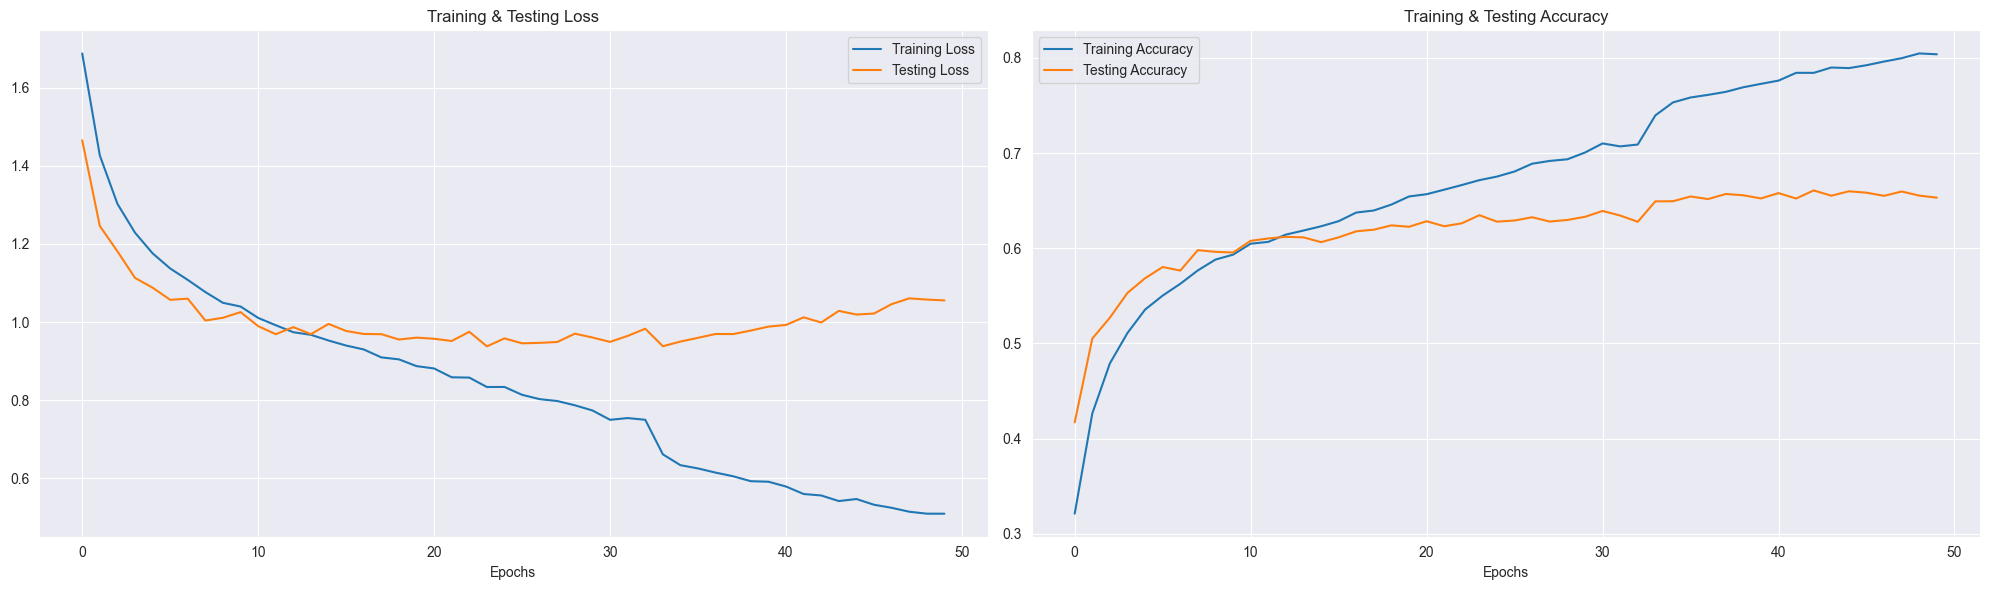

In [55]:
# Evaluate the model on the test data and print the accuracy
# The 'evaluate' method returns two values: loss and accuracy. We multiply the accuracy by 100 to get the percentage.
print("Accuracy of our model on test data: {:.2f}%".format(model.evaluate(x_test, y_test)[1] * 100))

# Plotting loss and accuracy for training and testing

epochs = list(range(50))  # List of epochs for plotting (50 epochs in total)

# Create subplots with two columns for loss and accuracy visualization
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot Loss: Training vs Testing
ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()  # Display the legend to differentiate between training and testing
ax[0].set_xlabel("Epochs")  # Label for the x-axis

# Plot Accuracy: Training vs Testing
ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()  # Display the legend to differentiate between training and testing
ax[1].set_xlabel("Epochs")  # Label for the x-axis

# Adjust the layout to prevent overlap between the plots
plt.tight_layout()
plt.show()

##### Chuẩn bị dữ liệu nhãn dự đoán và nhãn thật dưới dạng dễ đọc để phân tích kết quả mô hình (ma trận nhầm lẫn, báo cáo classification report, v.v.)

In [56]:
# Make predictions on the test set
# The 'predict' method returns the predicted probabilities for each class.
pred_test = model.predict(x_test)

# Convert the predicted probabilities to the actual class labels using the encoder
# 'inverse_transform' converts one-hot encoded predictions back to original labels
y_pred = encoder.inverse_transform(pred_test)

# Convert the actual labels (y_test) from one-hot encoding to original labels for comparison
y_test_labels = encoder.inverse_transform(y_test)

276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


##### So sánh trực quan nhãn dự đoán của mô hình (Predicted Labels) với nhãn thật của dữ liệu test (Actual Labels).

In [57]:
# Create a DataFrame to compare predicted labels with actual labels
# 'y_pred' contains the predicted labels and 'y_test_labels' contains the true labels

df = pd.DataFrame({
    'Predicted Labels': y_pred.flatten(),  # Flattening in case it's a multi-dimensional array
    'Actual Labels': y_test_labels.flatten()  # Flattening to match the structure of 'Predicted Labels'
})

# Display the first 10 rows of the DataFrame to compare predictions with actual labels
df.head(10)

,Predicted Labels,Actual Labels
0,happy,sad
1,angry,angry
2,angry,angry
3,calm,calm
4,neutral,neutral
5,happy,happy
6,fear,happy
7,sad,sad
8,disgust,neutral
9,fear,neutral


#### Ma trận nhầm lẫn (confusion matrix)

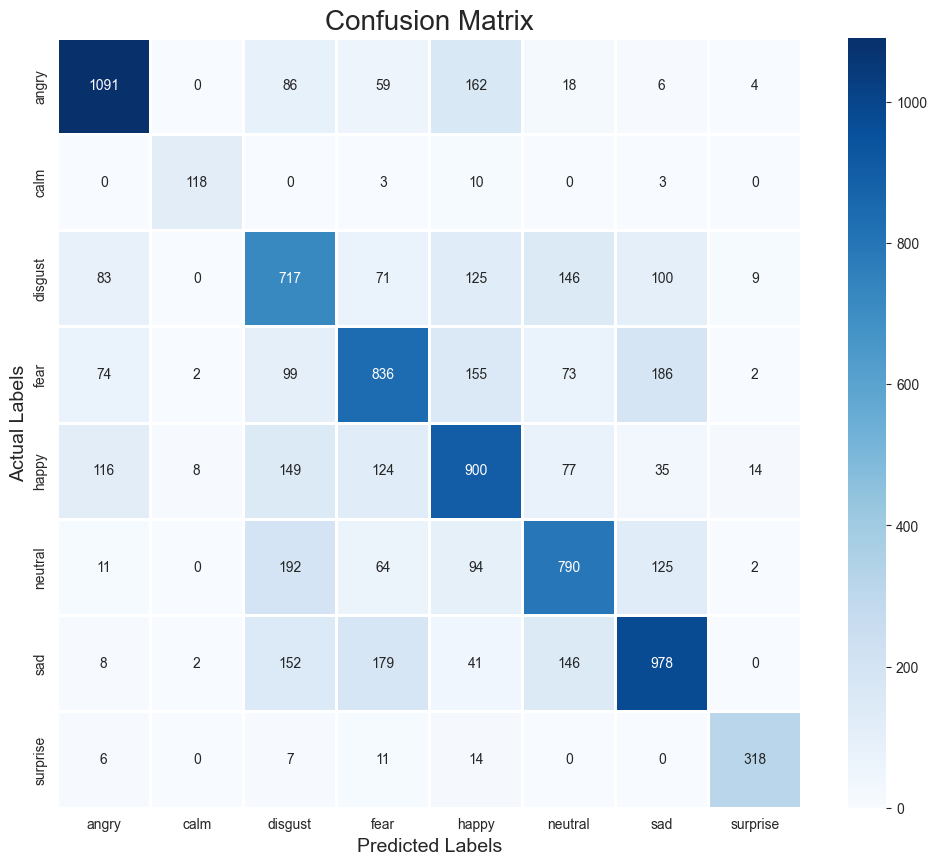

In [58]:
# Generate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Retrieve the list of labels from the encoder
labels = encoder.categories_[0]  # This will give the emotions in the same order as the encoder

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels),
            linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='d')

# Add titles and labels to the plot
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

# Display the plot
plt.show()

#### Báo cáo phân loại (classification report)

In [59]:
# Generate and print the classification report
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.77      0.78      1426
        calm       0.91      0.88      0.89       134
     disgust       0.51      0.57      0.54      1251
        fear       0.62      0.59      0.60      1427
       happy       0.60      0.63      0.62      1423
     neutral       0.63      0.62      0.62      1278
         sad       0.68      0.65      0.67      1506
    surprise       0.91      0.89      0.90       356

    accuracy                           0.65      8801
   macro avg       0.71      0.70      0.70      8801
weighted avg       0.66      0.65      0.65      8801



## IX. Xuất mô hình

In [66]:
# Export model for another usage
model.save("cnn_emotion_model.keras")